In [2]:
%cd /content/
!git --version
!git config --global user.email “thesirpotato514@gmail.com”
!git config --global user.name “louis zhu”

%cd APS360
!git pull origin main

/content
git version 2.34.1
fatal: destination path 'APS360' already exists and is not an empty directory.
/content/APS360
From https://github.com/zehuasong/APS360
 * branch            main       -> FETCH_HEAD
Already up to date.


###Segmentation

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def image_segmentation(img, debug=False):
    # 2) Threshold & Invert (so brackets/digits become white on black)
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))

    # 2) Apply closing
    thresh_closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # 4) Find Contours
    contours, _ = cv2.findContours(thresh_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bracket_contours = []
    other_contours = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h

        # Heuristic filters for bracket detection:
        # - Brackets might be tall and relatively thin (or short and wide)
        # - Adjust these thresholds to match your images
        aspect_ratio = w / float(h + 1e-5)  # avoid division by zero
        if 0.1 < aspect_ratio < 0.4:
            # This is likely a bracket (depending on orientation).
            bracket_contours.append((cnt, x, y, w, h))
        else:
            # Might be digits or noise
            other_contours.append((cnt, x, y, w, h))

    # If more than 4 brackets are detected, remove the ones with the smallest area.
    if len(bracket_contours) > 4:
        # Sort by area (w*h) in descending order so that the largest ones come first
        bracket_contours.sort(key=lambda bc: bc[3]*bc[4], reverse=True)
        # Keep only the 4 largest
        bracket_contours = bracket_contours[:4]

    # Sort bracket contours from left to right based on x coordinate
    bracket_contours.sort(key=lambda bc: bc[1])

    # For a 2×2 matrix side by side, you might expect 4 brackets total (2 for left matrix, 2 for right matrix).
    # bracket_contours = [ (cnt, x, y, w, h), ... ] sorted by x
    if debug: print(f"Found {len(bracket_contours)} potential bracket(s).")

    # Just for visualization: draw bracket bounding boxes on a copy of the image
    if debug:
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        for i, (cnt, x, y, w, h) in enumerate(bracket_contours):
            cv2.rectangle(img_color, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(img_color, f"B{i}", (x, y-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)

        plt.figure(figsize=(8, 6))
        plt.imshow(img_color[:,:,::-1])  # BGR -> RGB
        plt.title("Detected Brackets (Bounding Boxes)")
        plt.axis('off')
        plt.show()

    ###############################
    # 5) USE BRACKETS TO SEPARATE #
    ###############################
    # Example approach:
    # - Suppose bracket_contours[0] is the left bracket of the first matrix
    # - bracket_contours[1] is the right bracket of the first matrix
    # - bracket_contours[2] is the left bracket of the second matrix
    # - bracket_contours[3] is the right bracket of the second matrix

    if len(bracket_contours) >= 4:
        # Extract bounding boxes for the two matrix regions:
        # We'll define each matrix region from the right edge of its left bracket
        # to the left edge of its right bracket
        _, x1, y1, w1, h1 = bracket_contours[0]  # left bracket (matrix 1)
        _, x2, y2, w2, h2 = bracket_contours[1]  # right bracket (matrix 1)

        matrix1_left = x1 + w1
        matrix1_right = x2
        matrix1_top = min(y1, y2)
        matrix1_bottom = max(y1 + h1, y2 + h2)

        # Crop out the first matrix
        matrix1 = thresh[matrix1_top:matrix1_bottom, matrix1_left:matrix1_right]
        matrix1_color = img[matrix1_top:matrix1_bottom, matrix1_left:matrix1_right]

        _, x3, y3, w3, h3 = bracket_contours[2]  # left bracket (matrix 2)
        _, x4, y4, w4, h4 = bracket_contours[3]  # right bracket (matrix 2)

        matrix2_left = x3 + w3
        matrix2_right = x4
        matrix2_top = min(y3, y4)
        matrix2_bottom = max(y3 + h3, y4 + h4)

        # Crop out the second matrix
        matrix2 = thresh[matrix2_top:matrix2_bottom, matrix2_left:matrix2_right]
        matrix2_color = img[matrix2_top:matrix2_bottom, matrix2_left:matrix2_right]

        # Crop out operator
        op = thresh[:, matrix1_right + w2:matrix2_left - w3]
        op_color = img[:, matrix1_right + w2:matrix2_left - w3]

        # Display the two cropped matrices
        if debug:
            fig, axs = plt.subplots(1, 2, figsize=(8,4))
            axs[0].imshow(matrix1, cmap='gray')
            axs[0].set_title("Matrix 1")
            axs[0].axis('off')

            axs[1].imshow(matrix2, cmap='gray')
            axs[1].set_title("Matrix 2")
            axs[1].axis('off')

            plt.tight_layout()
            plt.show()
    else:
        print("Not enough bracket contours found to confidently separate the matrices.")
    return matrix1, matrix2, matrix1_color, matrix2_color, op, op_color


In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def should_merge(box1, box2, gap_ratio=0.1):
    """
    Determines if two boxes should be merged.

    Parameters:
      box1, box2: Each is a tuple (x, y, w, h).
      gap_ratio: If the boxes do not overlap, they will be merged if the gaps
                 in both x and y are less than gap_ratio times the longest side.

    Returns:
      True if the boxes overlap OR if they are close enough (within gap_ratio * longest_side).
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Compute the boundaries of each box
    box1_xmin, box1_ymin = x1, y1
    box1_xmax, box1_ymax = x1 + w1, y1 + h1
    box2_xmin, box2_ymin = x2, y2
    box2_xmax, box2_ymax = x2 + w2, y2 + h2

    # Check if boxes overlap:
    # They overlap if the rectangle defined by the intersection has positive width and height.
    inter_xmin = max(box1_xmin, box2_xmin)
    inter_ymin = max(box1_ymin, box2_ymin)
    inter_xmax = min(box1_xmax, box2_xmax)
    inter_ymax = min(box1_ymax, box2_ymax)

    if inter_xmax > inter_xmin and inter_ymax > inter_ymin:
        return True  # They overlap

    # They do not overlap. Compute the horizontal and vertical gaps:
    if box1_xmax < box2_xmin:
        gap_x = box2_xmin - box1_xmax
    elif box2_xmax < box1_xmin:
        gap_x = box1_xmin - box2_xmax
    else:
        gap_x = 0  # They are aligned horizontally

    if box1_ymax < box2_ymin:
        gap_y = box2_ymin - box1_ymax
    elif box2_ymax < box1_ymin:
        gap_y = box1_ymin - box2_ymax
    else:
        gap_y = 0  # They are aligned vertically

    # Determine the longest side among the two boxes
    longest_side = max(w1, h1, w2, h2)

    # Merge if both gaps are smaller than gap_ratio * longest_side.
    if gap_x < longest_side * gap_ratio and gap_y < longest_side * gap_ratio:
        return True

    return False

def merge_overlapping_boxes(boxes, gap_ratio=0.1):
    """
    Iteratively merge boxes that either overlap or are close to each other (within gap_ratio * longest_side).
    The merged box is the union of the boxes.

    Parameters:
      boxes: List of bounding boxes, each in (x, y, w, h) format.
      gap_ratio: Parameter used in the merging criteria.

    Returns:
      List of merged bounding boxes in (x, y, w, h) format.
    """
    # We'll perform iterative merging until no more boxes can be merged.
    merged = True
    while merged:
        merged = False
        new_boxes = []
        used = [False] * len(boxes)

        for i in range(len(boxes)):
            if used[i]:
                continue
            current_box = boxes[i]
            for j in range(i + 1, len(boxes)):
                if used[j]:
                    continue
                if should_merge(current_box, boxes[j], gap_ratio):
                    # Merge current_box and boxes[j] into their union.
                    x1 = min(current_box[0], boxes[j][0])
                    y1 = min(current_box[1], boxes[j][1])
                    x2 = max(current_box[0] + current_box[2], boxes[j][0] + boxes[j][2])
                    y2 = max(current_box[1] + current_box[3], boxes[j][1] + boxes[j][3])
                    current_box = (x1, y1, x2 - x1, y2 - y1)
                    used[j] = True
                    merged = True
            new_boxes.append(current_box)
        boxes = new_boxes
    return boxes

def find_objects(matrix, id, debug=False, size=-1):
    """
    Finds external contours in the thresholded image 'matrix', merges overlapping bounding boxes,
    and, if size is set to 2 or 3, ensures the final output has exactly 4 (for 2×2) or 9 (for 3×3)
    bounding boxes by removing the smallest ones.

    Parameters:
      matrix (numpy.ndarray): The thresholded input image (grayscale).
      id (str/int): Identifier for debugging display.
      debug (bool): If True, displays debug plots and prints debug information.
      size (int): If set to 2 or 3, the function will attempt to ensure the number of objects is
                  exactly 4 (2×2) or 9 (3×3). If left as -1, no such adjustment is performed.

    Returns:
      merged_boxes (list): List of merged (and possibly pruned) bounding boxes in (x, y, w, h) format.
    """
    # 1) Find contours
    contours, _ = cv2.findContours(
        matrix.copy(),
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    # --- Debug: Plot all detected bounding boxes (before filtering) ---
    if debug:
        debug_img = cv2.cvtColor(matrix, cv2.COLOR_GRAY2BGR)
        for i, cnt in enumerate(contours):
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (255, 0, 0), 2)  # Blue boxes
            cv2.putText(debug_img, f"B{i}", (x, max(y-5, 0)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Matrix {id} with ALL Detected Bounding Boxes")
        plt.axis("off")
        plt.show()

    # 2) Filter contours by area
    digit_contours = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        if debug:
            print("Contour area:", area)
        digit_contours.append(cnt)

    if debug:
        print(f"Total digit candidates found for matrix {id} after filtering: {len(digit_contours)}")

    # 3) Compute bounding boxes for the filtered contours
    boxes = [cv2.boundingRect(cnt) for cnt in digit_contours]

    # 4) Merge overlapping bounding boxes
    merged_boxes = merge_overlapping_boxes(boxes)

    # 5) If size parameter is 2 or 3, adjust the number of boxes to be exactly 4 or 9.
    if size in (2, 3):
        required_count = 4 if size == 2 else 9
        if len(merged_boxes) > required_count:
            # Remove the smallest boxes by area.
            merged_boxes.sort(key=lambda box: box[2] * box[3])
            # Keep the largest required_count boxes
            merged_boxes = merged_boxes[-required_count:]
        elif len(merged_boxes) < required_count:
            if debug:
                print(f"Warning: Expected {required_count} objects but found only {len(merged_boxes)}")

    # --- Debug: Plot the merged (and pruned) bounding boxes ---
    if debug:
        merged_img = cv2.cvtColor(matrix, cv2.COLOR_GRAY2BGR)
        for i, (x, y, w, h) in enumerate(merged_boxes):
            cv2.rectangle(merged_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(merged_img, f"M{i}", (x, max(y-5, 0)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(merged_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Matrix {id} with Merged Bounding Boxes")
        plt.axis("off")
        plt.show()

    return merged_boxes


In [5]:
def group_contours_by_rows(digit_contours, matrix, id, y_threshold=15, debug=False):
    """
    digit_contours: list of (cnt, x, y, w, h)
    y_threshold: vertical tolerance to consider two bounding boxes in the same row

    Returns a list of rows, where each row is a list of (cnt, x, y, w, h).
    """
    # 1) Compute the center y for each bounding box
    boxes = []
    for (x, y, w, h) in digit_contours:
        center_y = y + h/2.0
        boxes.append((x, y, w, h, center_y))

    # 2) Sort by center_y
    boxes.sort(key=lambda b: b[4])

    # 3) Group into rows
    rows = []
    current_row = [boxes[0]]

    for i in range(1, len(boxes)):
        prev_center_y = current_row[-1][4]
        current_center_y = boxes[i][4]

        # If the next box's center_y is within y_threshold of the last box in current row,
        # consider it part of the same row
        if abs(current_center_y - prev_center_y) < y_threshold:
            current_row.append(boxes[i])
        else:
            # Start a new row
            rows.append(current_row)
            current_row = [boxes[i]]

    # Add the final row
    rows.append(current_row)

    # 4) Sort each row by x, and sort rows by the average center_y
    sorted_rows = []
    for row in rows:
        row_sorted = sorted(row, key=lambda b: b[0])  # sort by x
        sorted_rows.append(row_sorted)
    # Sort rows by average y-center of each row
    sorted_rows.sort(key=lambda r: np.mean([box[4] for box in r]))

    # 5) Return rows without the extra center_y in each tuple
    # Each row is now in left-to-right order, and rows are top-to-bottom
    final_rows = []
    for row in sorted_rows:
        final_rows.append([(x, y, w, h) for (x, y, w, h, c_y) in row])

    max_len = max(len(row) for row in final_rows)

    # 3) Loop through each row and each digit, display them in subplots.
    digits = []
    for row in final_rows:
        for cnt_info in row:
            x, y, w, h = cnt_info
            digit_crop = matrix[y:y+h, x:x+w]
            digits.append(digit_crop)

    if debug:
        # 2) Create subplots with one row per detected "row of digits".
        num_rows = len(final_rows)
        fig, axes = plt.subplots(num_rows, max_len, figsize=(3*max_len, 3*num_rows))

        # Ensure axes is a 2D array even when there's only one row or one column
        if num_rows == 1:
            axes = np.expand_dims(axes, 0)
        if max_len == 1:
            axes = np.expand_dims(axes, 1)

        for i, row in enumerate(final_rows):
            for j in range(max_len):
                ax = axes[i][j]
                if j < len(row):
                    x, y, w, h = row[j]
                    digit_crop = matrix[y:y+h, x:x+w]
                    ax.imshow(digit_crop, cmap='gray')
                    ax.set_title(f"Row {i}, Col {j}")
                ax.axis('off')

        plt.suptitle(f"Extracted Digits for matrix {id}", fontsize=16)
        plt.tight_layout()
        plt.show()

    return digits

def crop_and_display_op(operator_contours, op_color, debug=False):
    cropped_ops = []
    num_ops = len(operator_contours)

    # Loop over each contour, crop the image, and display it.
    for (x, y, w, h) in operator_contours:
        cropped = op_color[y:y+h, x:x+w]
        cropped_ops.append(cropped)

    if debug:
        # Create a row of subplots for each cropped operator image
        fig, axes = plt.subplots(1, num_ops, figsize=(4*num_ops, 4))
        # If there's only one operator, axes is not a list, so we wrap it in a list.
        if num_ops == 1:
            axes = [axes]

        for idx, cropped in enumerate(cropped_ops):
            axes[idx].imshow(cropped, cmap='gray')
            axes[idx].set_title(f"Operator {idx}")
            axes[idx].axis('off')

        plt.suptitle(f"Matrix OP", fontsize=16)
        plt.tight_layout()
        plt.show()

    return cropped_ops

Run all segmentation process

Found 4 potential bracket(s).


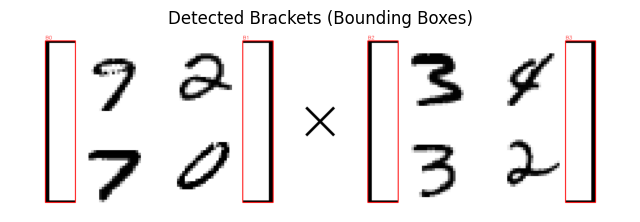

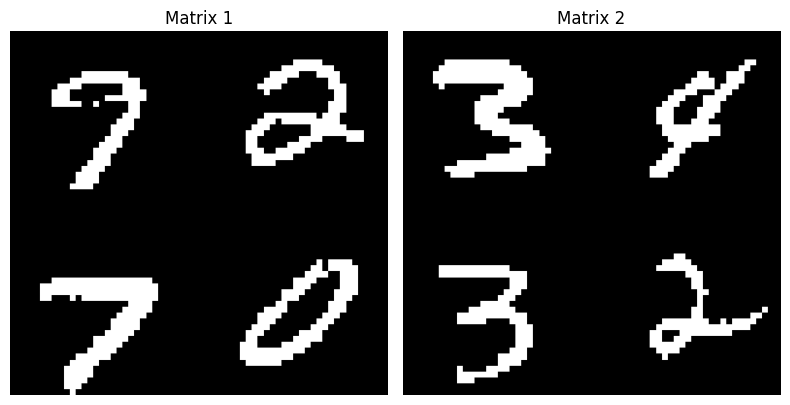

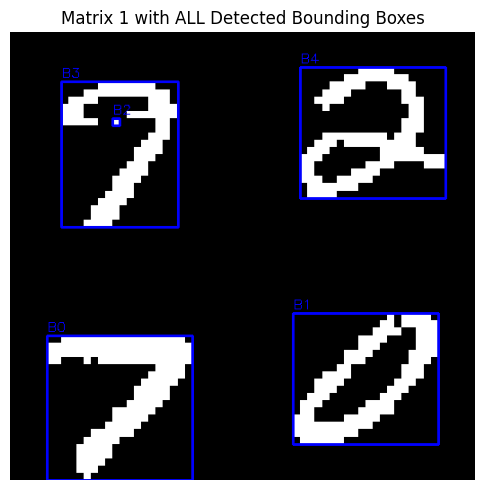

Contour area: 26082
Contour area: 23652
Contour area: 64
Contour area: 21060
Contour area: 23652
Total digit candidates found for matrix 1 after filtering: 5


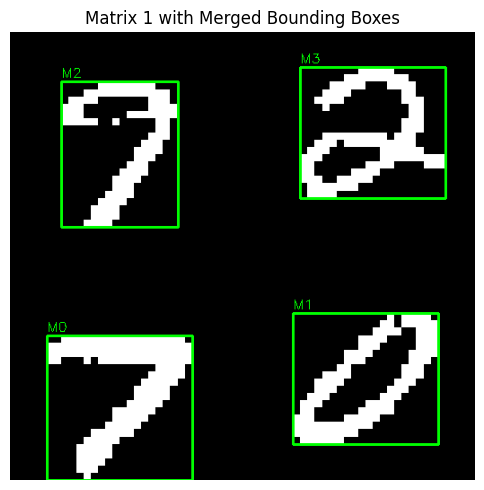

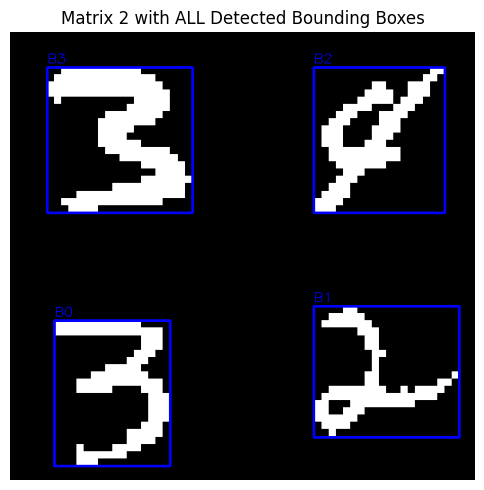

Contour area: 20898
Contour area: 23652
Contour area: 23652
Contour area: 26244
Total digit candidates found for matrix 2 after filtering: 4


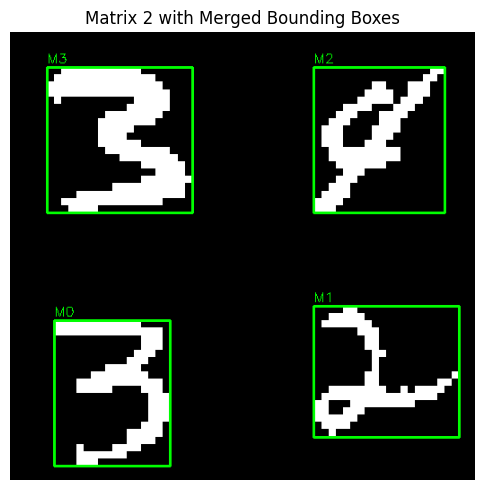

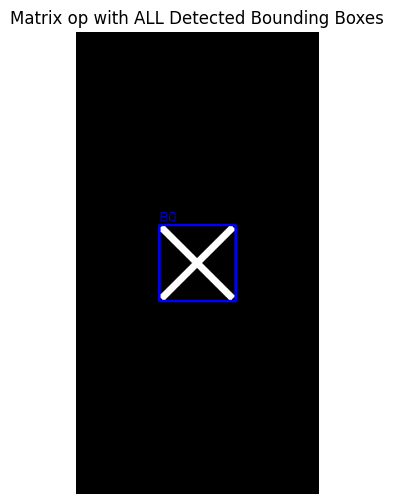

Contour area: 8464
Total digit candidates found for matrix op after filtering: 1


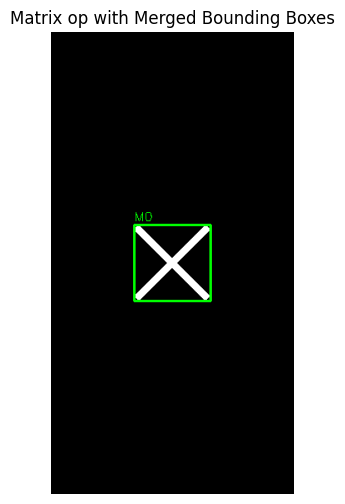

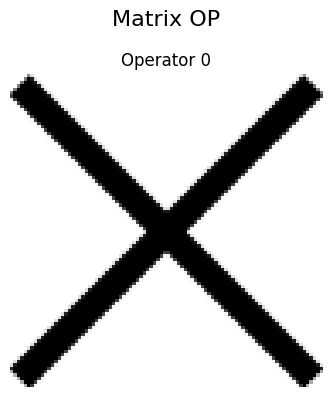

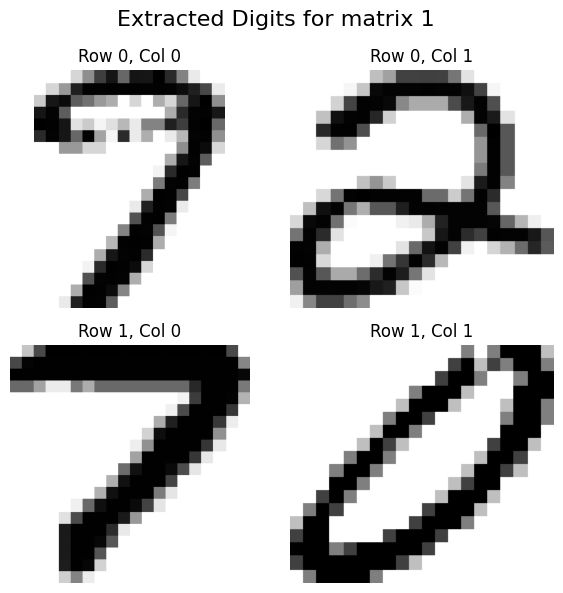

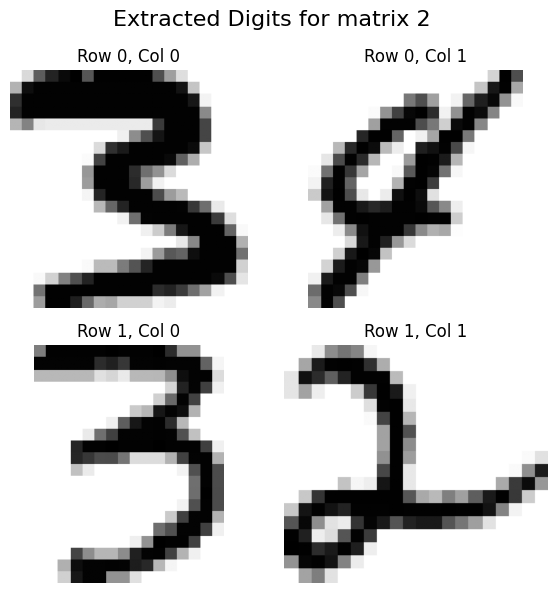

<Figure size 1000x500 with 0 Axes>

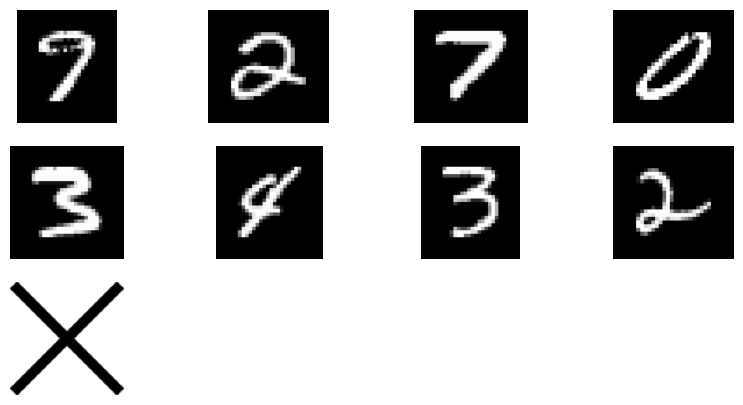

Found 4 potential bracket(s).


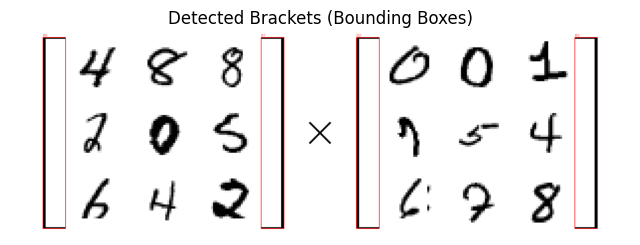

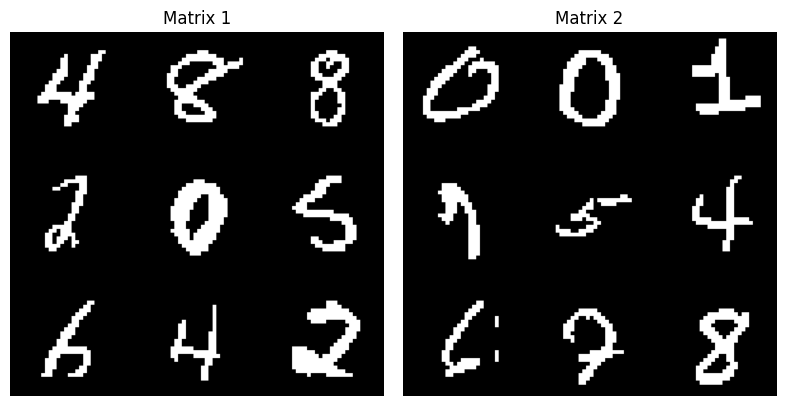

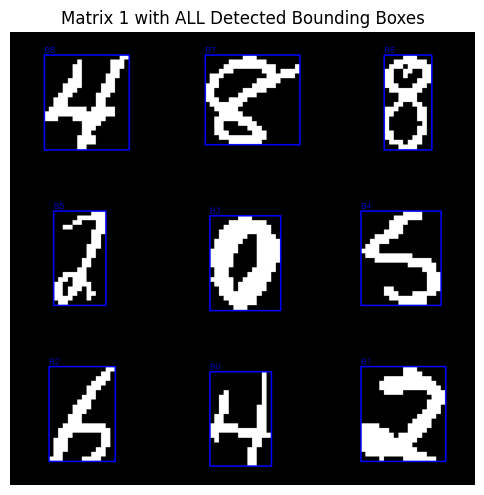

Contour area: 21658
Contour area: 30012
Contour area: 23424
Contour area: 25071
Contour area: 28210
Contour area: 18382
Contour area: 16836
Contour area: 31659
Contour area: 30012
Total digit candidates found for matrix 1 after filtering: 9


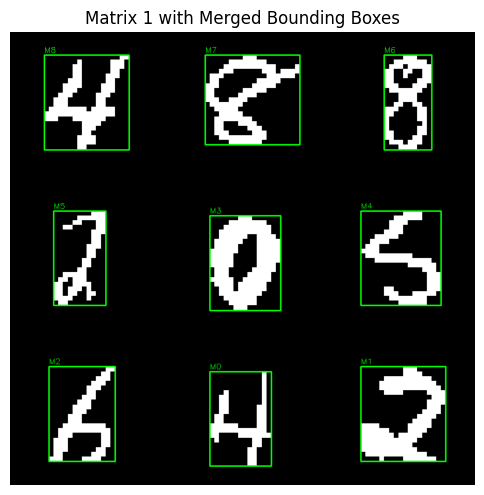

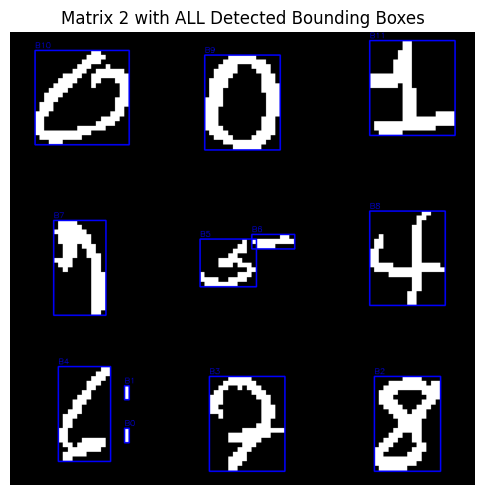

Contour area: 252
Contour area: 243
Contour area: 23424
Contour area: 26718
Contour area: 18483
Contour area: 10028
Contour area: 2324
Contour area: 18483
Contour area: 26572
Contour area: 26718
Contour area: 33124
Contour area: 30195
Total digit candidates found for matrix 2 after filtering: 12


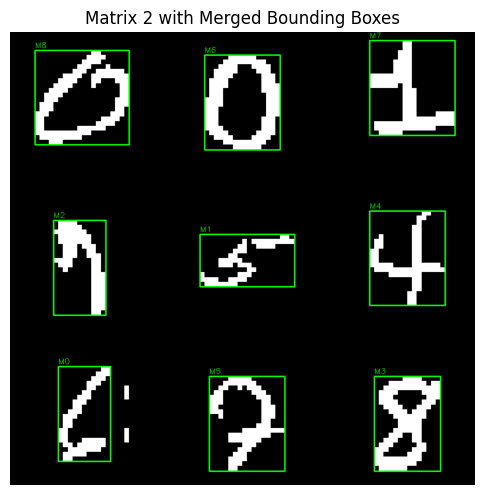

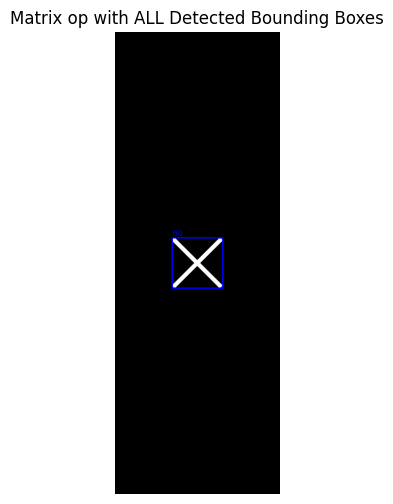

Contour area: 10404
Total digit candidates found for matrix op after filtering: 1


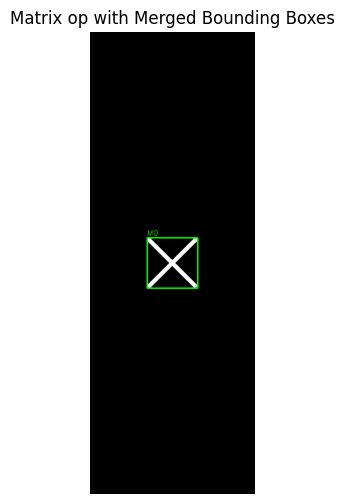

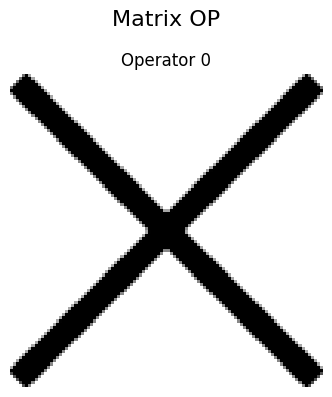

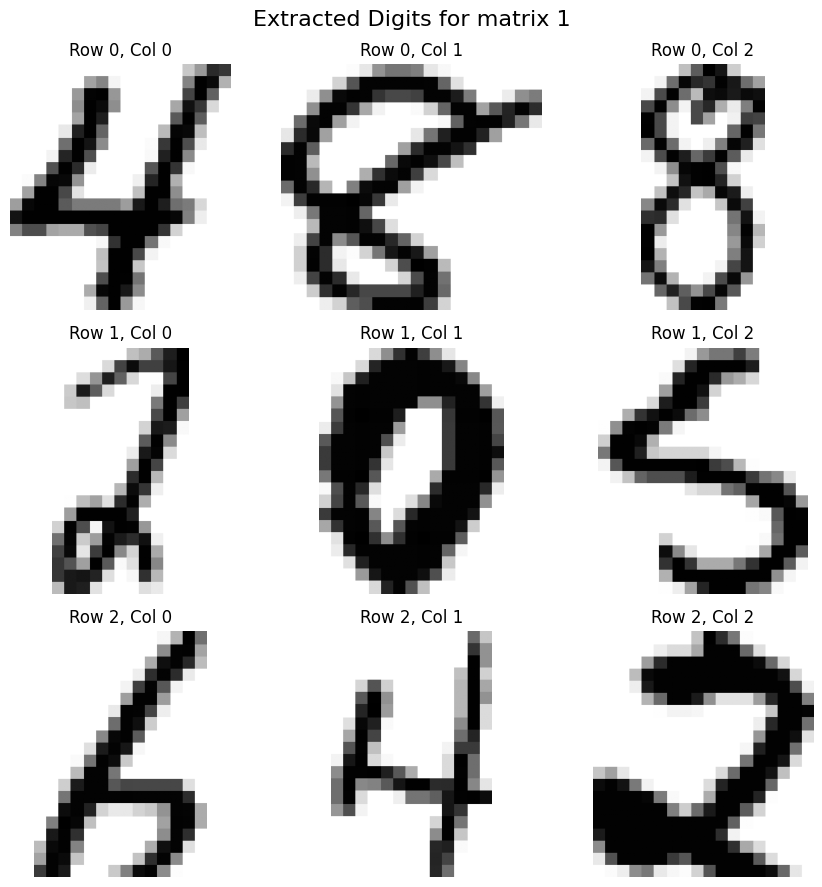

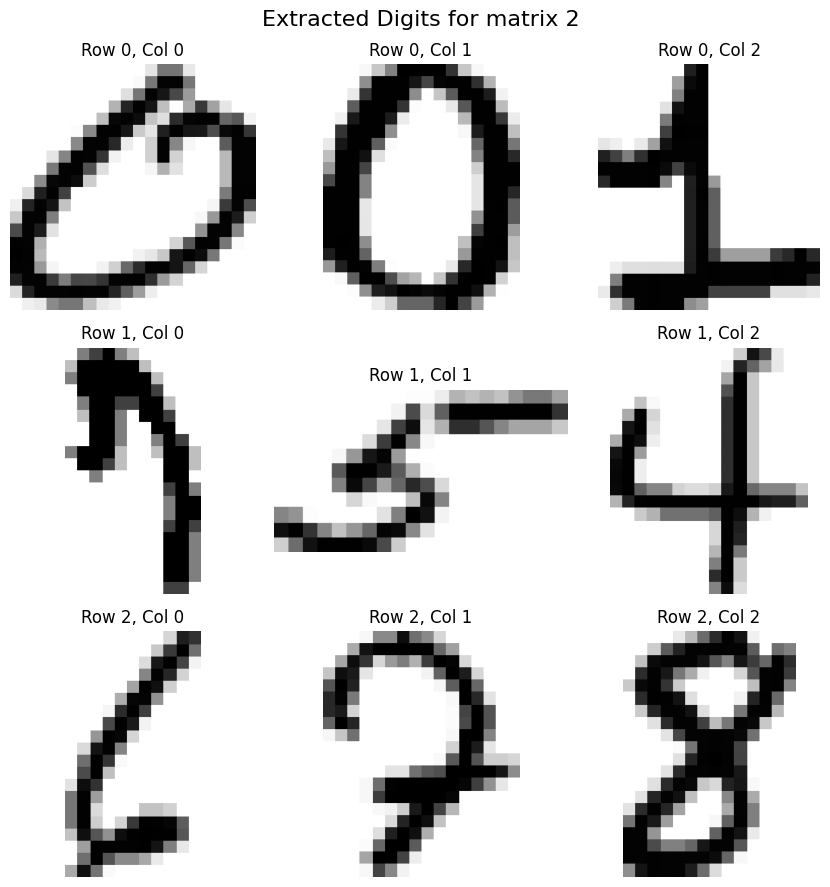

<Figure size 1000x500 with 0 Axes>

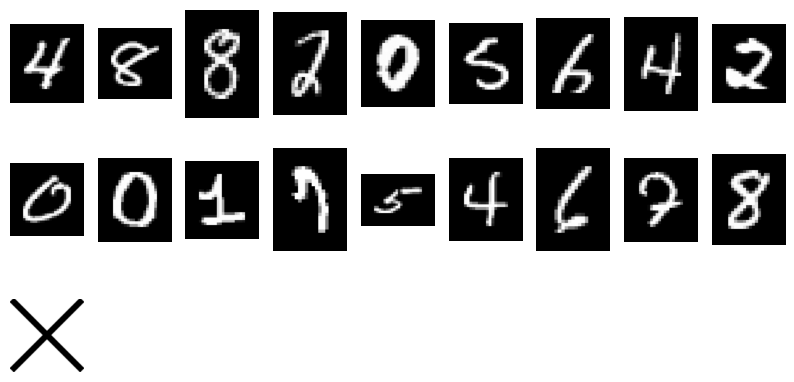

In [7]:
import torch
import torch.nn.functional as F
from PIL import Image
import os
import shutil

def adaptive_pooling(image_list, output_size=(28, 28)):
    """
    Apply adaptive pooling to resize images to a fixed size.
    """
    processed_images = []
    for img in image_list:
        if img is None or not isinstance(img, np.ndarray) or img.size == 0:
            continue

        # # Convert to tensor
        # img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Ensure channel dimension

        # # Adaptive Pooling
        # pooled_img = F.adaptive_avg_pool2d(img_tensor.unsqueeze(0), output_size).squeeze(0)

        # # Convert back to numpy and remove extra dimension
        # pooled_img_np = pooled_img.numpy().astype(np.uint8).squeeze()

        # Convert to PIL Image
        pil_image = Image.fromarray(img)
        processed_images.append(pil_image)

    return processed_images

def flatten_list(nested_list):
    """Flatten a list of lists into a single list."""
    flat_list = []
    for sublist in nested_list:
        if isinstance(sublist, list):
            flat_list.extend(sublist)  # Add all elements if it's a list
        else:
            flat_list.append(sublist)  # Add element directly if it's not a list
    return flat_list

def matrix_segmentation(img, debug=False, size=-1):
    matrix1, matrix2, matrix1_color, matrix2_color, op, op_color = image_segmentation(img, debug)
    digit_contours_1 = find_objects(matrix1, 1, debug, size)
    digit_contours_2 = find_objects(matrix2, 2, debug, size)
    operator_contours = find_objects(op, "op", debug, size)
    cropped_op = crop_and_display_op(operator_contours, op_color, debug)
    digits_1 = group_contours_by_rows(digit_contours_1, matrix1_color, 1, 150, debug)
    digits_2 = group_contours_by_rows(digit_contours_2, matrix2_color, 2, 150, debug)

    # Invert the images before pooling (White digits on black background)
    digits_1 = [cv2.bitwise_not(img) for img in flatten_list(digits_1)]
    digits_2 = [cv2.bitwise_not(img) for img in flatten_list(digits_2)]

    # Add black padding around each digit before pooling
    def add_black_padding(images, pad=50):
        return [cv2.copyMakeBorder(img, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=[0, 0, 0]) for img in images]

    digits_1 = add_black_padding(digits_1)
    digits_2 = add_black_padding(digits_2)

    # Apply Adaptive Pooling
    pooled_digits_1 = adaptive_pooling(digits_1)
    pooled_digits_2 = adaptive_pooling(digits_2)
    pooled_op = adaptive_pooling(cropped_op)  # Treat same as digits

    # Display results
    if debug:
        plt.figure(figsize=(10, 5))

        max_len = max(len(pooled_digits_1), len(pooled_digits_2), len(pooled_op))

        plt.figure(figsize=(10, 5))

        for i, img in enumerate(pooled_digits_1):
            plt.subplot(3, max_len, i + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')

        for i, img in enumerate(pooled_digits_2):
            plt.subplot(3, max_len, max_len + i + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')

        for i, img in enumerate(pooled_op):
            plt.subplot(3, max_len, 2 * max_len + i + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')

        plt.show()

    return pooled_digits_1, pooled_digits_2, pooled_op[0]

def save_processed_images(images, folder_name):
    """Save processed PIL images into a specified folder."""
    if os.path.exists(folder_name):
        shutil.rmtree(folder_name)  # Remove existing directory
    os.makedirs(folder_name, exist_ok=True)

    for i, img in enumerate(images):
        img_path = os.path.join(folder_name, f"image_{i}.png")
        img.save(img_path)

img = cv2.imread('MNIST_dataset_op/test/images/2x2_45.png', cv2.IMREAD_GRAYSCALE)
digits_1_2x2, digits_2_2x2, cropped_op_2x2 = matrix_segmentation(img, debug=True, size=2)

# save_processed_images(digits_1_2x2, "sample_test2/digits_1_2x2")
# save_processed_images(digits_2_2x2, "sample_test2/digits_2_2x2")
# save_processed_images([cropped_op_2x2], "sample_test2/cropped_op_2x2")

img = cv2.imread('MNIST_dataset_op/test/images/3x3_45.png', cv2.IMREAD_GRAYSCALE)
digits_1_3x3, digits_2_3x3, cropped_op_3x3 = matrix_segmentation(img, debug=True, size=3)

# save_processed_images(digits_1_3x3, "testing_processed_data/digits_1_3x3")
# save_processed_images(digits_2_3x3, "testing_processed_data/digits_2_3x3")
# save_processed_images([cropped_op_3x3], "testing_processed_data/cropped_op_3x3")

In [8]:
import os
import cv2
import shutil

def process_all_images(base_dir="MNIST_dataset_op", subsets=("train", "val", "test"), debug=False):
    """
    For each subset (train, val, test) in 'base_dir':
      1. Reads all images from 'images/' folder.
      2. Runs matrix_segmentation on each image.
      3. Creates a new folder structure under 'cropped_digits/<image_name>/'.
      4. Saves the cropped digits from matrix 1 in 'digits_1/' and from matrix 2 in 'digits_2/'.

    Example final structure for an image named '2x2_0.png':
        MNIST_dataset_op/test/cropped_digits/2x2_0/digits_1/
        MNIST_dataset_op/test/cropped_digits/2x2_0/digits_2/
    """

    # Loop over each subset
    for subset in subsets:
        images_dir = os.path.join(base_dir, subset, "images")
        cropped_dir = os.path.join(base_dir, subset, "cropped_digits")
        if os.path.exists(cropped_dir):
            shutil.rmtree(cropped_dir)
        os.makedirs(cropped_dir, exist_ok=True)

        # Go through each image in the images folder
        for filename in sorted(os.listdir(images_dir)):
            if not filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
                continue  # Skip non-image files

            image_path = os.path.join(images_dir, filename)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"[Warning] Could not read image: {image_path}")
                continue

            # Decide if it's a 2×2 or 3×3 matrix, or default
            if "2x2" in filename.lower():
                size_param = 2
            elif "3x3" in filename.lower():
                size_param = 3
            else:
                size_param = -1  # Default assumption (adjust if needed)
                print(f"[Warning] Unexpected file name: {image_path}")

            # Run your segmentation function (import or define it elsewhere)
            # This should return lists of PIL Image objects for digits_1, digits_2, plus an operator if needed.
            digits_1, digits_2, cropped_op = matrix_segmentation(img, debug=debug, size=size_param)

            # Build the subfolder for this image (use the filename without extension)
            base_name, _ = os.path.splitext(filename)
            image_subfolder = os.path.join(cropped_dir, base_name)

            # Create separate subfolders for matrix1 (digits_1) and matrix2 (digits_2)
            digits_1_folder = os.path.join(image_subfolder, "digits_1")
            digits_2_folder = os.path.join(image_subfolder, "digits_2")

            # Save the cropped digits using your provided save_processed_images function
            save_processed_images(digits_1, digits_1_folder)
            save_processed_images(digits_2, digits_2_folder)

            print(f"Processed {filename}, saved digits to {image_subfolder}")


process_all_images(base_dir="MNIST_dataset_op", subsets=("test", "train", "val"), debug=False)


Processed 2x2_0.png, saved digits to MNIST_dataset_op/test/cropped_digits/2x2_0
Processed 2x2_1.png, saved digits to MNIST_dataset_op/test/cropped_digits/2x2_1
Processed 2x2_10.png, saved digits to MNIST_dataset_op/test/cropped_digits/2x2_10
Processed 2x2_11.png, saved digits to MNIST_dataset_op/test/cropped_digits/2x2_11
Processed 2x2_12.png, saved digits to MNIST_dataset_op/test/cropped_digits/2x2_12
Processed 2x2_13.png, saved digits to MNIST_dataset_op/test/cropped_digits/2x2_13
Processed 2x2_14.png, saved digits to MNIST_dataset_op/test/cropped_digits/2x2_14
Processed 2x2_15.png, saved digits to MNIST_dataset_op/test/cropped_digits/2x2_15
Processed 2x2_16.png, saved digits to MNIST_dataset_op/test/cropped_digits/2x2_16
Processed 2x2_17.png, saved digits to MNIST_dataset_op/test/cropped_digits/2x2_17
Processed 2x2_18.png, saved digits to MNIST_dataset_op/test/cropped_digits/2x2_18
Processed 2x2_19.png, saved digits to MNIST_dataset_op/test/cropped_digits/2x2_19
Processed 2x2_2.png,

# model

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DigitNet(nn.Module):
    def __init__(self, num_classes=10):
        super(DigitNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x
class OperatorNet(nn.Module):
    def __init__(self, num_classes=3):
        super(OperatorNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, num_classes)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [34]:
import torch
import torch.nn.functional as F
from torchvision import transforms

operator_map = {
    0: "+",
    1: "-",
    2: "×"
}

# Transform for digit model (expects 1 channel)
digit_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale (1 channel)
    transforms.ToTensor()
])

# Transform for operator model (expects 3 channels)
operator_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=3),  # Ensure 3 channels for OperatorNet
    transforms.ToTensor()
])

def rec_operation(list1, list2, operator, digit_model, operator_model):
  digit_model.eval()
  operator_model.eval()
  recognized_digits_1 =[]
  for img in list1:
    x = digit_transform(img).unsqueeze(0)
    with torch.no_grad():
      logits = digit_model(x)
      pred = logits.argmax(dim=-1)
    recognized_digits_1.append(pred.item())
  recognized_digits_2 =[]
  for img in list2:
    x = digit_transform(img).unsqueeze(0)
    with torch.no_grad():
      logits = digit_model(x)
      pred = logits.argmax(dim=-1)
    recognized_digits_2.append(pred.item())
  op_x = operator_transform(operator).unsqueeze(0)
  with torch.no_grad():
    logits = operator_model(op_x)
    pred = logits.argmax(dim=-1)
  # print(f"Predicted operator index: {pred.item()}")  # Debugging output
  operator_pred = operator_map[pred.item()]
  return recognized_digits_1, recognized_digits_2, operator_pred

In [64]:
# Initialize model architectures
digit_model = DigitNet()  # Replace with your actual model class
operator_model = OperatorNet()  # Replace with your actual model class

# Load the saved state dictionaries
digit_model.load_state_dict(torch.load("checkpoint/model_DigitNet_bs64_lr0.01_epoch24"))
operator_model.load_state_dict(torch.load("checkpoint/model_OperatorNet_bs32_lr0.01_epoch9"))

digits1_2x2, digits2_2x2, op_2x2 = rec_operation(digits_1_2x2, digits_2_2x2, cropped_op_2x2, digit_model, operator_model)
digits1_3x3, digits2_3x3, op_3x3 = rec_operation(digits_1_3x3, digits_2_3x3, cropped_op_3x3, digit_model, operator_model)

In [35]:
import numpy as np
def perform_operation(list1, list2, operator):
    dmatrix1=[int(d) for d in list1]
    dmatrix2=[int(d) for d in list2]
    if(len(dmatrix1) == 4) and (len(dmatrix2) == 4):
      size=2
    elif len(dmatrix1) == 9 and len(dmatrix2) == 9:
      size =3
    else:
      return None, None, None
    matrix1= np.array(dmatrix1).reshape(size,size)
    matrix2= np.array(dmatrix2).reshape(size,size)
    if operator == '+':
        result = matrix1 + matrix2
    elif operator == '-':
        result = matrix1 - matrix2
    elif operator == '×':
        result = np.matmul(matrix1, matrix2)
    else:
        return None, None, None

    return matrix1, matrix2, result

In [65]:
m1, m2, res = perform_operation(digits1_2x2, digits2_2x2, op_2x2)
print("Matrix 1:\n", m1)
print("Matrix 2:\n", m2)
print("Op:\n", op_2x2)
print("Result:\n", res)
m1, m2, res = perform_operation(digits1_3x3, digits2_3x3, op_3x3)
print("Matrix 1:\n", m1)
print("Matrix 2:\n", m2)
print("Op:\n", op_3x3)
print("Result:\n", res)

Matrix 1:
 [[1 2]
 [3 4]]
Matrix 2:
 [[5 6]
 [3 8]]
Op:
 +
Result:
 [[ 6  8]
 [ 6 12]]
Matrix 1:
 [[4 8 8]
 [2 0 5]
 [1 4 2]]
Matrix 2:
 [[0 0 2]
 [7 5 4]
 [6 7 8]]
Op:
 ×
Result:
 [[104  96 104]
 [ 30  35  44]
 [ 40  34  34]]


In [62]:
import cv2
import torch
import numpy as np
import os

def evaluate_computation():
    image_dir = "MNIST_dataset_op/test/images/"
    label_file_2x2 = "MNIST_dataset_op/test/labels_2x2.npy"
    label_file_3x3 = "MNIST_dataset_op/test/labels_3x3.npy"

    # Load labels
    labels_2x2 = np.load(label_file_2x2)
    labels_3x3 = np.load(label_file_3x3)

    # Initialize model architectures
    digit_model = DigitNet()  # Replace with your actual model class
    operator_model = OperatorNet()  # Replace with your actual model class

    # Load the saved state dictionaries
    digit_model.load_state_dict(torch.load("checkpoint/model_DigitNet_bs64_lr0.01_epoch24"))
    operator_model.load_state_dict(torch.load("checkpoint/model_OperatorNet_bs32_lr0.01_epoch9"))

    correct_2x2 = 0
    total_2x2 = 0
    correct_3x3 = 0
    total_3x3 = 0

    # Iterate over 2x2 images
    for i in range(len(labels_2x2)):
        image_path = os.path.join(image_dir, f"2x2_{i}.png")
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Skipping missing image: {image_path}")
            continue

        # Segment the image
        digits_1_2x2, digits_2_2x2, cropped_op_2x2 = matrix_segmentation(img, debug=False, size=2)

        # Run the forward pass
        digits1_2x2, digits2_2x2, op_2x2 = rec_operation(digits_1_2x2, digits_2_2x2, cropped_op_2x2, digit_model, operator_model)

        # Compute result
        m1, m2, res = perform_operation(digits1_2x2, digits2_2x2, op_2x2)

        # Check if res is None (error case)
        if res is None:
            print(f"Error encountered in computation for {image_path}, skipping.")
            continue

        # Compare with ground truth
        if np.array_equal(res, labels_2x2[i]):
            correct_2x2 += 1
        total_2x2 += 1

    # Iterate over 3x3 images
    for i in range(len(labels_3x3)):
        image_path = os.path.join(image_dir, f"3x3_{i}.png")
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Skipping missing image: {image_path}")
            continue

        # Segment the image
        digits_1_3x3, digits_2_3x3, cropped_op_3x3 = matrix_segmentation(img, debug=False, size=3)

        # Run the forward pass
        digits1_3x3, digits2_3x3, op_3x3 = rec_operation(digits_1_3x3, digits_2_3x3, cropped_op_3x3, digit_model, operator_model)

        # Compute result
        m1, m2, res = perform_operation(digits1_3x3, digits2_3x3, op_3x3)

        # Check if res is None (error case)
        if res is None:
            print(f"Error encountered in computation for {image_path}, skipping.")
            continue

        # Compare with ground truth
        if np.array_equal(res, labels_3x3[i]):
            correct_3x3 += 1
        total_3x3 += 1

    # Compute accuracy
    accuracy_2x2 = (correct_2x2 / total_2x2) * 100 if total_2x2 > 0 else 0
    accuracy_3x3 = (correct_3x3 / total_3x3) * 100 if total_3x3 > 0 else 0

    print(f"2x2 Matrix Computation Accuracy: {accuracy_2x2:.2f}%")
    print(f"3x3 Matrix Computation Accuracy: {accuracy_3x3:.2f}%")


evaluate_computation()

2x2 Matrix Computation Accuracy: 72.92%
3x3 Matrix Computation Accuracy: 29.17%
